#### This notebook implements a video animation of connectivity matrices in the sequnce of epochs.

In [1]:
from inspect import isfunction, ismethod, isgeneratorfunction, isgenerator, isroutine
from inspect import isabstract, isclass, ismodule, istraceback, isframe, iscode, isbuiltin
from inspect import ismethoddescriptor, isdatadescriptor, isgetsetdescriptor, ismemberdescriptor
from inspect import isawaitable, iscoroutinefunction, iscoroutine

from collections.abc import Iterable as iterable

from pickle import load, dump

def isfx(field): return ismethod(field) or isfunction(field)

class GhostSet:
    """ enhanced interface (ghost) to retrieve class fields """
    def _meta(data): return {k:v for k,v in data.__dict__.items() if not isfx(v)}
    def _at_last(_, sets): pass
    def _set(object, **sets):
        ''' use to fast initialize fields | needed to avoid initialization problems at copy by value '''
        for field in sets: setattr(object, field, sets[field])
        object._at_last(sets)
GSet = GhostSet

def meta(object):
    ''' retrieves clonable object metadata (__dict__) as a copy '''
    if isinstance(object, GSet): return object._meta()
    return {}

class ClonableObjectGhost:
    """ enhanced interface (ghost) for clonable objects """
    def _by_val(_, depth=-1, _layer=0): pass
GCo = ClonableObjectGhost

class ClonableObject(GSet, GCo):
    """ base clonable object """
    def __init__(this, **data): this._set(**data)
    def __call__(_, **options): _._set(**options)
    def _by_val(_, depth=-1, _layer=0):
        copy = type(_)()
        copy._set(**_._meta())
        if depth<0 or depth>_layer:
            for field in copy.__dict__:
                if isinstance(copy.__dict__[field], ClonableObjectGhost):
                    copy.__dict__[field] = copy.__dict__[field]._by_val(depth,_layer+1)
        return copy
COb = ClonableObject

def copy_by_val(object, depth=-1, _layer=0):
    if isinstance(object, GCo): return object._by_val(depth,_layer)
    return object
copy = by_val = vof = copy_by_val

class ComparableGhost:
    """ enhanced interface (ghost) for comparing instances """
    def _compare(a, b):
        if type(a) != type(b): return False
        if a.__dict__ == b.__dict__: return True
        return False
    def __eq__(a, b): return a._compare(b)
GEq = ComparableGhost

class IterableObjectGhost(GSet):
    """ enhanced interface (ghost) for iterables: exposes __dict__,
        therefore Iterable Objects are like lua dictionaries """
    def __contains__(this, key): return key in this.__dict__
    def __iter__(this): return iter(this.__dict__)
    def items(my): return my.__dict__.items()
    def __getitem__(by, field): return by.__dict__[field]
    def __setitem__(by, field, value): by.__dict__[field] = value
    def pop(by, field): return by.__dict__.pop(field)
GIo = IterableObjectGhost

class ReprGhost:
    """ enhanced interface (ghost) for the skeleton method _repr,
        see implementation of Struct for a working example;
        Record __repr__ override uses _lines_ for max lines display """
    _lines_ = 31
    _chars_ = 13
    _msgsz_ = 62
    _ellipsis_ = ' ... '
    def _repr(my, value):
        _type = ''.join(''.join(str(type(value)).split('class ')).split("'"))
        _value = '{}'.format(value)
        if len(_value)>my._chars_:
            show = int(my._chars_/2)
            _value = _value[:show]+my._ellipsis_+_value[-show:]
        return '{} {}'.format(_type, _value)
    def _resize(this, message, at=.7):
        if len(message)>this._msgsz_:
            start = int(at*this._msgsz_)
            end = this._msgsz_-start
            return message[:start]+this._ellipsis_+message[-end:]
        return message
GRe = ReprGhost

def set_repr_to(lines): GRe._lines_ = lines

class Struct(COb, GEq, GIo, GRe):
    """ structured autoprintable object, behaves like a lua dictionary """
    def __repr__(_):
        return '\n'.join(['{}:\t{}'.format(k, _._repr(v)) for k,v in _.items()])
struct = Struct

class RecordableGhost:
    """ enhanced interface (ghost) for type recording,
        see Record for a working example """
    @staticmethod
    def load(filename):
        with open(filename, 'rb') as file: return load(file)
    def save(data, filename):
        with open(filename, 'wb') as file: dump(data, file)
        
GRec = RecordableGhost

class Record(GSet, GCo, GRec, GEq, GRe):
    """ wrapper for any object or value, auto-inspects and provides load/save type structure """
    data = None
    _check = dict(
            isfunction=isfunction, ismethod=ismethod, isgeneratorfunction=isgeneratorfunction, isgenerator=isgenerator, isroutine=isroutine,
            isabstract=isabstract, isclass=isclass, ismodule=ismodule, istraceback=istraceback, isframe=isframe, iscode=iscode, isbuiltin=isbuiltin,
            ismethoddescriptor=ismethoddescriptor, isdatadescriptor=isdatadescriptor, isgetsetdescriptor=isgetsetdescriptor, ismemberdescriptor=ismemberdescriptor,
            isawaitable=isawaitable, iscoroutinefunction=iscoroutinefunction, iscoroutine=iscoroutine
                   )
    def __init__(this, token, **meta):
        this.data = token
        this.__dict__.update({k:v(token) for k,v in this._check.items()})
        super()._set(**meta)
    @property
    def type(_): return type(_.data)
    def inherits(_, *types): return issubclass(_.type, types)
    @property
    def isbaseiterable(_): return _.inherits(tuple, list, dict, set) or _.isgenerator or _.isgeneratorfunction
    @property
    def isiterable(_): return isinstance(_.data, iterable) and _.type is not str
    def _clone_iterable(_):
        if _.inherits(dict): return _.data.copy()
        elif _.isgenerator or _.isgeneratorfunction: return (i for i in list(_.data))
        else: return type(_.data)(list(_.data)[:])
    def _meta(data): return {k:v for k,v in data.__dict__.items() if k != 'data' and not isfx(v)}
    def _by_val(_, depth=-1, layer=0):
        data = _.data
        if _.isiterable: data = _._clone_iterable()
        elif _.inherits(ClonableObjectGhost): data = by_val(data, depth, layer)
        return type(_)(data, **meta(_))
    def __enter__(self): self._instance = self; return self
    def __exit__(self, type, value, traceback): self._instance = None
    def __repr__(self):
        if not hasattr(self, '_preprint'): return Record(self.data, _preprint='', _lines=Record(Record._lines_)).__repr__()
        if self.isbaseiterable:
            pre, repr = self._preprint, ''
            for n,i in enumerate(self.data):
                if self._lines.data == 0: break
                else: self._lines.data -= 1
                index, item = str(n), i
                if self.inherits(dict): index += ' ({})'.format(str(i)); item = self.data[i]
                repr += pre+'{}: '.format(index)
                next = Record(item, _preprint=pre+'\t', _lines=self._lines)
                if next.isiterable: repr += '\n'
                repr += next.__repr__()
                repr += '\n'
            return repr
        elif self.inherits(GCo): return Record(self.data._meta(), _preprint=self._preprint, _lines=self._lines).__repr__()
        else: return self._repr(self.data)
REc = Record

class Bisect(list, COb):
    """ bisect implementation using clonable objects """
    def __init__(set, *items, key=None, reverse=False):
        if not key: key = lambda  x:x
        super().__init__(sorted(items, reverse=reverse, key=key))
    def _bisect(set, item, key, reverse, bottom, top):
        def _(check):
            if key: return key(check)
            return check
        at = int((top-bottom)/2)+bottom
        if len(set)==0: return (0,-1)
        if item==_(set[at]): return (at,0)
        bigger = item<_(set[at])
        if bigger != reverse:
            if at-bottom>0: return set._bisect(item, key, reverse, bottom, at)
            return (at,-1)
        elif top-at>1: return set._bisect(item, key, reverse, at, top)
        return (at,1)
    def search(_, item, key=None, reverse=False):
        if not key: key = lambda x:x
        return _._bisect(item, key, reverse, 0, len(_))
    def _by_val(_, depth=-1, _layer=0):
        copy = super()._by_val(depth, _layer)
        copy += _[:]
        return copy
BSx = Bisect

In [2]:
import matplotlib.pyplot as plt

main_folder = "/home/kivi/gdrive-tmp/Karla_epigame_cluster/"

path_cm = main_folder + "connectivity_matrices/" 

In [31]:
subject_id = "1"
measure = "SCR"
band = "(0,4)"

woi = "preseizure1"

print("WOI:", woi)

nodes = ['P1-P2', 'P4-P5', 'P8-P9', 'P9-P10', 'P10-P11', 'G1-G2', 'G8-G9', 'G9-G10', 'G10-G11', 'G11-G12', 'M1-M2', 'M8-M9', 'M9-M10', 'M10-M11', 'M11-M12', 'O1-O2', 'O2-O3', 'O5-O6', 'O6-O7', 'F1-F2', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'F12-F13', 'A1-A2', 'A2-A3', 'A3-A4', 'A7-A8', 'A8-A9', 'A9-A10', 'A10-A11', 'B1-B2', 'B2-B3', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'C1-C2', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q4-Q5', 'Q8-Q9', 'Q9-Q10', 'Q10-Q11', 'Q11-Q12', 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'T10-T11', 'T11-T12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'E9-E10', 'E10-E11', 'L1-L2', 'L2-L3', 'L5-L6', 'L6-L7', 'L7-L8', 'U1-U2', 'U2-U3', 'U3-U4', 'U4-U5', 'U5-U6', 'U6-U7', 'J1-J2', 'J10-J11', 'J11-J12', 'J12-J13', 'J13-J14', 'J14-J15']
node_ids = list(range(len(nodes))) 
print("Number of nodes =",len(nodes))

resection = ['A3-A4', 'B2-B3', 'B5-B6', 'B6-B7', 'D3-D4', 'D4-D5', 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'T10-T11', 'T11-T12']
print("Number of nodes in the resection =", len(resection))

WOI: preseizure1
Number of nodes = 98
Number of nodes in the resection = 17


In [32]:
nodes_rearranged = resection + [node for node in nodes if node not in resection]

In [25]:
file_cm = f"{subject_id}-{woi}-{measure}-{band}.prep"

cm = REc.load(path_cm + file_cm).data

woi_ep_i = cm.i[0:int(len(cm.i)/2)]

sequence = {} # Main dictionary for storing epochs in a sorted sequence, as their sequence was randomized before saving to .PREP files

# Load epochs (59 random epochs from a WOI) into a dictionary 
sequence_randomized = {ep_i:cm.X[i] for i,ep_i in enumerate(woi_ep_i)}
# Update the sequence dictionary with sorted epochs
sequence.update({k: sequence_randomized[k] for k in sorted(woi_ep_i)})

print("Total epoch number from all considered WOIs =", len(sequence))

Total epoch number from all considered WOIs = 119


In [33]:
import numpy as np

def rearrange_matrix(connectivity_matrix, original_nodes, sorted_nodes):
    # Create a dictionary with node pair tuples as keys and connectivity values as values
    connectivity_dict = {}
    for i, node1 in enumerate(sorted_nodes):
        for j, node2 in enumerate(sorted_nodes):
            connectivity_dict[(node1, node2)] = connectivity_matrix[original_nodes.index(node1), original_nodes.index(node2)]

    # Create a new matrix using node labels
    rearranged_matrix = np.zeros_like(connectivity_matrix)
    for i, node1 in enumerate(sorted_nodes):
        for j, node2 in enumerate(sorted_nodes):
            rearranged_matrix[i, j] = connectivity_dict.get((node1, node2), 0.0)

    return rearranged_matrix

# Example usage:
# Assuming 'your_matrix' is your connectivity matrix, 'node_labels' is a list of labels, and 'resection_labels' is a list of labels to be ordered first
# rearranged_result = rearrange_matrix(your_matrix, node_labels, resection_labels)
# m = np.array([[0,0,0],[1,1,1],[0,0,1]])
# plt.matshow(m)
# rm = rearrange_matrix(m, ["A","B","C"], ["C","A","B"])
# plt.matshow(rm)


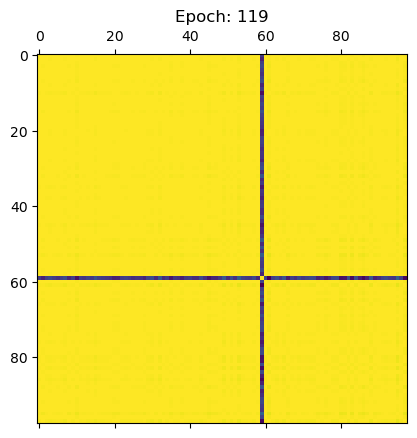

In [34]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Assuming you have a list of connectivity matrices called 'connectivity_matrices'
# Each matrix is a 2D numpy array

connectivity_matrices = [rearrange_matrix(cm, nodes, nodes_rearranged) for cm in list(sequence.values())]

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Define the update function for the animation
def update(frame):
    ax.clear()  # Clear the previous plot
    matrix = connectivity_matrices[frame]
    cax = ax.matshow(matrix, cmap='viridis')  # Display the connectivity matrix
    plt.title(f'Epoch: {frame + 1}')

# Create the animation and assign it to a variable
animation = FuncAnimation(fig, update, frames=len(connectivity_matrices), interval=1000)

# Show the animation
animation.save("cm-animation-1-preseizure1.gif", writer=PillowWriter(fps=1))
plt.show()
